<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>



## Read UNGDC

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=';')

df_un_merged = df_speech.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='ISO-alpha3 Code', right_on='ISO-alpha3 Code')
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)
df_un_merged["Speech"] = df_un_merged["Speech"].str.lower()


## Run bag of words

In [2]:
count_vect = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=10)
X_counts = count_vect.fit_transform(df_un_merged["Speech"])
words_list = count_vect.get_feature_names_out()
X_counts = pd.DataFrame(X_counts.toarray(), columns=words_list)


## Merge UNGDC with bag of words

In [3]:
df_un_merged = df_un_merged.reset_index().merge(X_counts, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)


## Read happiness report and merge with country codes to get ISO-alpha3 Code

In [4]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls')
df_happiness_merged = happinessdataframe.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='Country name', right_on='Country or Area')
df_happiness_merged.set_index(['year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.index.rename(['Year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.drop(columns=['Country name','Country or Area'], inplace=True)

## Merge UNGDC with happiness report by Multiple index Year, ISO

In [5]:
df_un_merged = df_un_merged.merge(df_happiness_merged, how='left', left_index=True, right_index=True)

## Build Regression for Life Ladder

### remove NaN rows from Life Ladder

In [6]:
# remove na from rows
x=df_un_merged.dropna(subset=['Life Ladder'])

### Split data set

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


Y = x['Life Ladder'].values
X = x[count_vect.get_feature_names_out()]

# splitting the data
x_rem, x_test, y_rem, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.3, random_state = 42)






### Hyperparameters tunning based grid search on validation data set

In [8]:
# Create grid of parameters to test through cross-validation
param_grid = {'polynomialfeatures__degree': np.arange(2)}

model = make_pipeline( PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(x_valid, y_valid);


/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cach

### Fit the best estimator on train set

In [9]:
grid.best_estimator_.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [10]:
y_pred = grid.best_estimator_.predict(x_test)

# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")

Model accuracy:
Mean squared error: 0.58
Variance score: 0.49



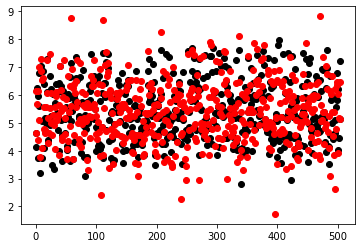

In [11]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0,len(y_test)),y_test, c='black')
ax.scatter(np.arange(0,len(y_pred)),y_pred, c='red')
plt.show()